In [45]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import GaussianNB


import os
import random as rn

os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)
rn.seed(42)

sns.set()

In [46]:
print(tf.__version__)

2.12.0


In [47]:
#load balanced dataset with no milticolinearity
diabetes=pd.read_csv('diabetes_prepross.csv')

#split targets and inputs
targets1=diabetes['Diabetes']
inputs1=diabetes.drop(['Diabetes'],axis=1)

In [48]:
#shuffle the data
inputs1=np.asarray(inputs1)
shuffled_indices=np.arange(inputs1.shape[0])
np.random.shuffle(shuffled_indices)

In [49]:
#shuffle the data
shuffled_indices=np.arange(inputs1.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs=inputs1[shuffled_indices]
shuffled_targets=targets1[shuffled_indices]

In [50]:
#split the dataset into training, validation and test
samples_count=shuffled_inputs.shape[0]
train_samples_count=int(0.8*samples_count)
validation_samples_count=int(0.1*samples_count)
test_samples_count=samples_count-(train_samples_count+validation_samples_count)

train_inputs=shuffled_inputs[:train_samples_count]
train_targets=shuffled_targets[:train_samples_count]

validation_inputs=shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets=shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

test_inputs=shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets=shuffled_targets[train_samples_count+validation_samples_count:]

In [51]:
#standarize the inputs

scaler=StandardScaler()
quantile_reg=QuantileTransformer(output_distribution='normal')

train_inputs=quantile_reg.fit_transform(train_inputs)
train_inputs=scaler.fit_transform(train_inputs)


validation_inputs=quantile_reg.transform(validation_inputs)
validation_inputs=scaler.transform(validation_inputs)


test_inputs=quantile_reg.transform(test_inputs)
test_inputs=scaler.transform(test_inputs)


# scaled_inputs1=preprocessing.scale(inputs1)

In [52]:
#save the datasets in npz format
np.savez('diabetes_data_train',inputs=train_inputs,targets=train_targets)
np.savez('diabetes_data_validation',inputs=validation_inputs,targets=validation_targets)
np.savez('diabetes_data_test',inputs=test_inputs,targets=test_targets)

In [53]:
npz=np.load('diabetes_data_test.npz')

In [54]:
#load the data

#training data
npz=np.load('diabetes_data_train.npz')
train_inputs=npz['inputs'].astype(np.float_)
train_targets=npz['targets'].astype(np.int_)

#validation data
npz=np.load('diabetes_data_validation.npz')
validation_inputs=npz['inputs'].astype(np.float_)
validation_targets=npz['targets'].astype(np.int_)

npz=np.load('diabetes_data_test.npz')
test_inputs=npz['inputs'].astype(np.float_)
test_targets=npz['targets'].astype(np.int_)

In [55]:
#create the model

input_size=14 #number of parameters
output_size=2 # number of outputs (yes or no, classification problem)
hidden_layer_size=70 # quite of a magic number (input_size * 5)

#programming and early stop to prevent overfitting
early_stop=tf.keras.callbacks.EarlyStopping(patience=2)

# 2 hidden layers
model=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size,activation='relu'),
    tf.keras.layers.Dense(output_size,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

batch_size=100
max_epochs=100

history=model.fit(train_inputs,
    train_targets,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(validation_inputs,validation_targets),
    callbacks=[early_stop],
    verbose=2)

Epoch 1/100
503/503 - 2s - loss: 0.5703 - accuracy: 0.7093 - val_loss: 0.5621 - val_accuracy: 0.7180 - 2s/epoch - 4ms/step
Epoch 2/100
503/503 - 1s - loss: 0.5640 - accuracy: 0.7148 - val_loss: 0.5620 - val_accuracy: 0.7153 - 808ms/epoch - 2ms/step
Epoch 3/100
503/503 - 1s - loss: 0.5624 - accuracy: 0.7144 - val_loss: 0.5608 - val_accuracy: 0.7154 - 811ms/epoch - 2ms/step
Epoch 4/100
503/503 - 1s - loss: 0.5618 - accuracy: 0.7152 - val_loss: 0.5619 - val_accuracy: 0.7165 - 827ms/epoch - 2ms/step
Epoch 5/100
503/503 - 1s - loss: 0.5608 - accuracy: 0.7163 - val_loss: 0.5607 - val_accuracy: 0.7169 - 802ms/epoch - 2ms/step
Epoch 6/100
503/503 - 1s - loss: 0.5602 - accuracy: 0.7159 - val_loss: 0.5631 - val_accuracy: 0.7151 - 836ms/epoch - 2ms/step
Epoch 7/100
503/503 - 1s - loss: 0.5599 - accuracy: 0.7174 - val_loss: 0.5588 - val_accuracy: 0.7167 - 820ms/epoch - 2ms/step
Epoch 8/100
503/503 - 1s - loss: 0.5594 - accuracy: 0.7167 - val_loss: 0.5617 - val_accuracy: 0.7134 - 764ms/epoch - 2ms/

In [56]:
#test the model
test_loss,test_accuracy=model.evaluate(test_inputs,test_targets)
print(test_loss)
print(test_accuracy)

197/197 [==============================] - 0s 1ms/step - loss: 0.5561 - accuracy: 0.7233
0.5560511946678162
0.7232754230499268


In [57]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


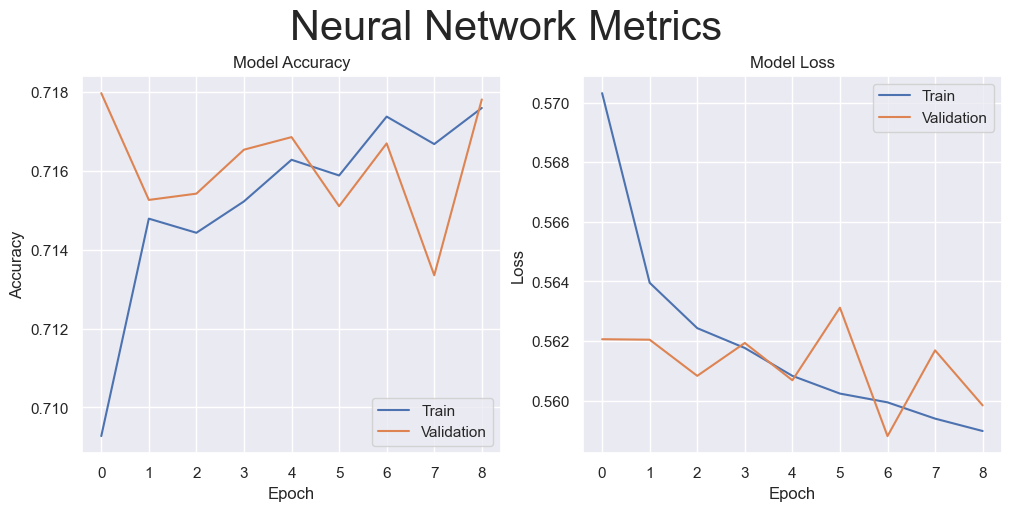

In [58]:
fig1=plt.figure(constrained_layout=True,figsize=(10,5))
axs1=fig1.add_gridspec(1,2)

axs1_0=fig1.add_subplot(axs1[0,0])
axs1_0.plot(history.history['accuracy'])
axs1_0.plot(history.history['val_accuracy'])
axs1_0.set_title('Model Accuracy')
axs1_0.set_ylabel('Accuracy')
axs1_0.set_xlabel('Epoch')
axs1_0.legend(['Train','Validation'],loc='best')

axs1_1=fig1.add_subplot(axs1[0,1])
axs1_1.plot(history.history['loss'])
axs1_1.plot(history.history['val_loss'])
axs1_1.set_title('Model Loss')
axs1_1.set_ylabel('Loss')
axs1_1.set_xlabel('Epoch')
axs1_1.legend(['Train','Validation'],loc='best')

fig1.suptitle('Neural Network Metrics',size=30)

plt.show()

#If validation accuracy is less than the training accuracy then the model is overfitting 

In [59]:
#plot confusion matrix
predict_x=model.predict(test_inputs) 
y_prediction=np.argmax(predict_x,axis=1)


197/197 [==============================] - 0s 1ms/step


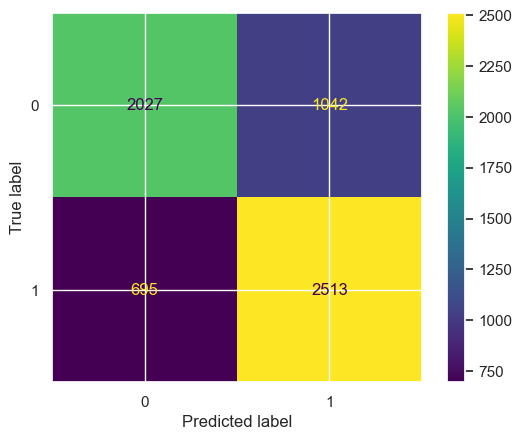

In [60]:
c_matrix1=confusion_matrix(test_targets,y_prediction)
cm_display1=ConfusionMatrixDisplay(confusion_matrix=c_matrix1,display_labels=unique_labels(test_targets))
cm_display1.plot()

In [61]:
diabetes=pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
print(diabetes.columns)
print(sorted(diabetes['MentHlth'].unique()))
print(sorted(diabetes['PhysHlth'].unique()))
print(sorted(diabetes['GenHlth'].unique()))
print(sorted(diabetes['BMI'].unique()))
print(sorted(diabetes['Income'].unique()))


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 

In [62]:
diabetes=pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')


diabetes_yes=diabetes.drop(index=(diabetes[diabetes['Diabetes_binary']!=1]).index)
diabetes_no=diabetes.drop(index=(diabetes[diabetes['Diabetes_binary']!=0]).index)

# dropping quantiles sup 5% and low 5%
q=diabetes_yes['BMI'].quantile(1-0.05)
diabetes_yes=diabetes_yes[diabetes_yes['BMI']<q]
q=diabetes_yes['BMI'].quantile(0.05)
diabetes_yes=diabetes_yes[diabetes_yes['BMI']>q]

q=diabetes_no['BMI'].quantile(1-0.05)
diabetes_no=diabetes_no[diabetes_no['BMI']<q]
q=diabetes_no['BMI'].quantile(0.05)
diabetes_no=diabetes_no[diabetes_no['BMI']>q]

diabetes_yes=diabetes_yes.reset_index(drop=True)
diabetes_no=diabetes_no.reset_index(drop=False)


df_heat=pd.concat([diabetes_yes,diabetes_no])
df_heat=df_heat.reset_index(drop=True)
df_heat=df_heat.drop(['index'],axis=1)

In [63]:
df_heat=pd.concat([diabetes_yes,diabetes_no])
df_heat=df_heat.reset_index(drop=True)
df_heat=df_heat.drop(['index'],axis=1)

df_heat=df_heat.rename(columns={'Diabetes_binary':'Diabetes','HighBP':'High blood preassure','HighChol':'High cholesterol',
'HeartDiseaseorAttack':'Heart disease','PhysActivity':'Excercise','Fruits':'Daily fruits','Veggies':'Daily vegetables','HvyAlcoholConsump':'Heavy drinker',
'DiffWalk':'Difficulty walking','AnyHealthcare':'Has insurance','NoDocbcCost':"Can't afford doctor",'GenHlth':'General health',
'MentHlth':'Mental health','PhysHlth':'Physical health','CholCheck':'Had cholesterol checked at least once'})

variables=df_heat.drop(['Diabetes'],axis=1)
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features']=variables.columns

print(vif)

          VIF                               Features
0    3.072632                   High blood preassure
1    2.508489                       High cholesterol
2   33.911910  Had cholesterol checked at least once
3   31.490927                                    BMI
4    2.045819                                 Smoker
5    1.165332                                 Stroke
6    1.398607                          Heart disease
7    3.935401                              Excercise
8    2.826439                           Daily fruits
9    5.198811                       Daily vegetables
10   1.065811                          Heavy drinker
11  23.293838                          Has insurance
12   1.220596                    Can't afford doctor
13  13.322766                         General health
14   1.500393                          Mental health
15   2.202130                        Physical health
16   2.043093                     Difficulty walking
17   2.073862                                 

In [64]:
df_heat=df_heat.drop(['Income','Education','Age','General health','Has insurance','Had cholesterol checked at least once','BMI'],axis=1) #no multico

In [65]:
#regression models

targets1=df_heat['Diabetes']
inputs1=df_heat.drop(['Diabetes'],axis=1)

#Test train split
X_train, X_test, y_train, y_test=train_test_split(inputs1,targets1,test_size=0.3,random_state=42)

#scale the data
scaler=StandardScaler()
quantile_reg=QuantileTransformer(output_distribution='normal')

X_train_quantile=quantile_reg.fit_transform(X_train)
X_test_quantile=quantile_reg.transform(X_test)

X_train_scaled=scaler.fit_transform(X_train_quantile)
X_test_scaled=scaler.transform(X_test_quantile)

#Gaussian naive Bayes
glf=GaussianNB()
glf.fit(X_train_scaled,y_train)

#Logistic regression
log_reg=LogisticRegression(solver='saga',
C=0.1,warm_start=True,penalty="l2",
fit_intercept=False,
max_iter=10000,random_state=42).fit(X_train_scaled,y_train)
prediction1=log_reg.predict(X_test_scaled)
prediction2=glf.predict(X_test_scaled)

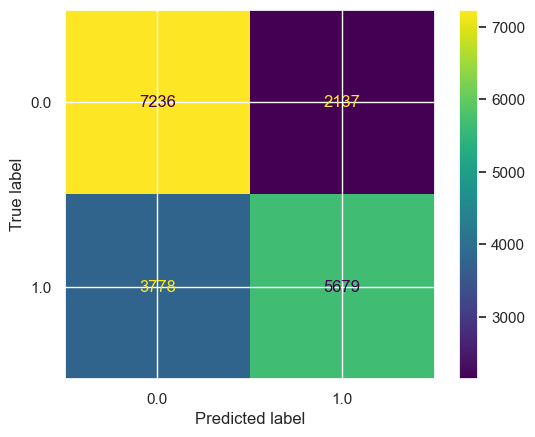

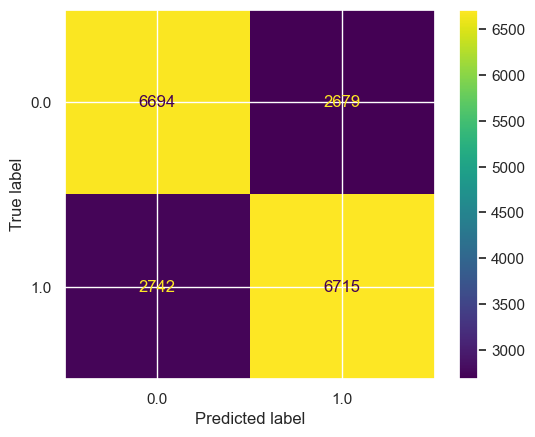

In [66]:
#Evaluating 

#logistic regression confusion matrix
c_matrix1=confusion_matrix(y_test, glf.predict(X_test_scaled))
c_matrix2=confusion_matrix(y_test, log_reg.predict(X_test_scaled))

cm_display1=ConfusionMatrixDisplay(confusion_matrix=c_matrix1,display_labels=unique_labels(y_test))
cm_display2=ConfusionMatrixDisplay(confusion_matrix=c_matrix2,display_labels=unique_labels(y_test))
cm_display1.plot()
cm_display2.plot()


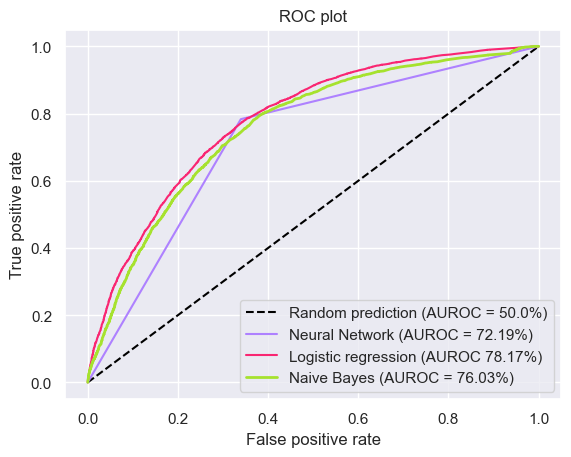

In [67]:
monokai_colors=['#a6e22e','#f92672','#66d9ef','#fd971f','#ae81ff','#e6db74',"#fd5ff0",'#a1efe4','#272828','#75715e']

# plot roc
r_probs=[0 for _ in range(len(test_targets))]

r_auc=roc_auc_score(test_targets,r_probs)
model_auc=roc_auc_score(test_targets,y_prediction)
log_reg_probs=log_reg.predict_proba(X_test_scaled)
glf_probs=glf.predict_proba(X_test_scaled)

#keeping positives probs
log_reg_probs=log_reg_probs[:,1]
glf_probs=glf_probs[:,1]

#auroc
log_reg_auc=roc_auc_score(y_test, log_reg_probs)
glf_auc=roc_auc_score(y_test, glf_probs)


#Calculate the curve
r_fpr, r_tpr, _ =roc_curve(test_targets,r_probs)
model_fpr, model_tpr, _=roc_curve(test_targets,y_prediction)
log_reg_auc_fpr, log_reg_auc_tpr,_=roc_curve(y_test, log_reg_probs)
glf_auc_fpr, glf_auc_tpr,_=roc_curve(y_test, glf_probs)

plt.plot(r_fpr,r_tpr,label=f'Random prediction (AUROC = {round(r_auc*100,2)}%)',c='black', linestyle='--')
plt.plot(model_fpr,model_tpr,label=f'Neural Network (AUROC = {round(model_auc*100,2)}%)',c='#ae81ff')
plt.plot(log_reg_auc_fpr,log_reg_auc_tpr,label=f"Logistic regression (AUROC {round(log_reg_auc*100,2)}%)",c=monokai_colors[1])
plt.plot(glf_auc_fpr,glf_auc_tpr,label=f"Naive Bayes (AUROC = {round(glf_auc*100,2)}%)",c=monokai_colors[0],linewidth=2)

plt.title('ROC plot')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')


0.6644682056162383
0.7833541147132169


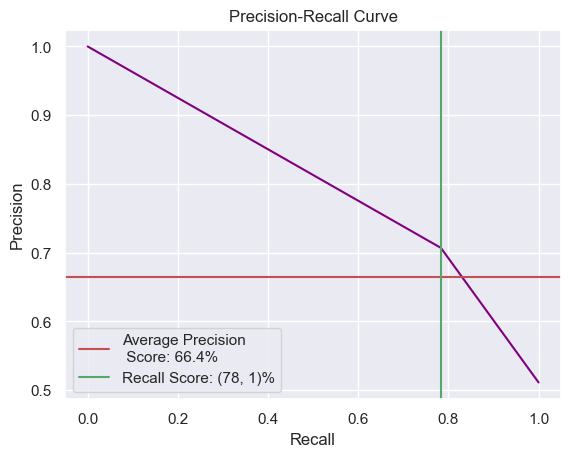

In [68]:
#plot precision recall
precision, recall, thresholds=precision_recall_curve(test_targets,y_prediction)
precision_av_score=average_precision_score(test_targets,y_prediction)
av_recall_score=recall_score(test_targets,y_prediction)
print(precision_av_score)
print(av_recall_score)

fig,ax=plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(y = precision_av_score, color = 'r', linestyle = '-',label=f'Average Precision\n Score: {round(precision_av_score*100,1)}%')
ax.axvline(av_recall_score,color='g',label=f'Recall Score: {round(av_recall_score*100),1}%')

ax.legend()

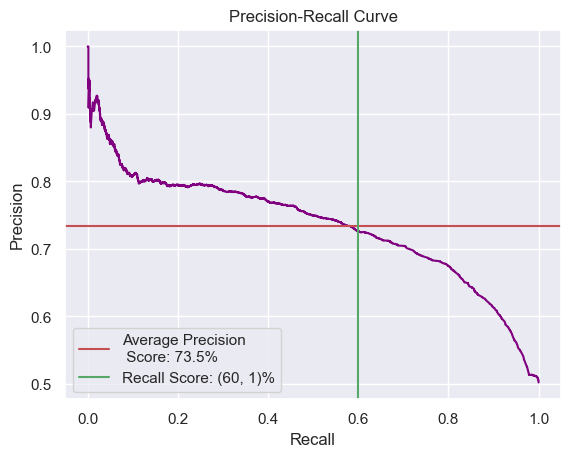

In [69]:

#calculate precision and recall
precision, recall, thresholds=precision_recall_curve(y_test, glf_probs)
precision_av_score=average_precision_score(y_test, glf_probs)
av_recall_score=recall_score(y_test,prediction2)

fig,ax=plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(y = precision_av_score, color = 'r', linestyle = '-',label=f'Average Precision\n Score: {round(precision_av_score*100,1)}%')
ax.axvline(av_recall_score,color='g',label=f'Recall Score: {round(av_recall_score*100),1}%')

ax.legend()


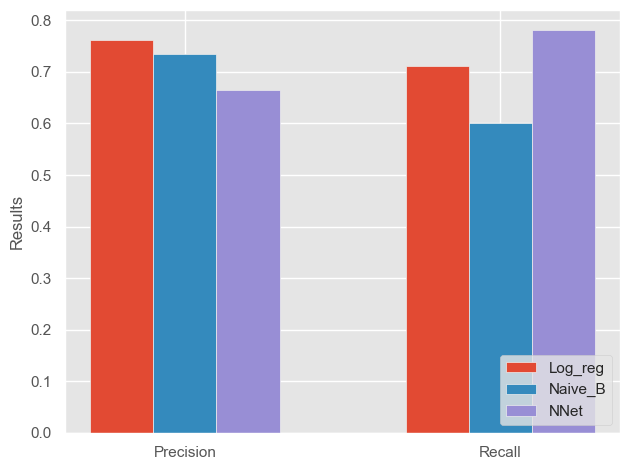

In [70]:
plt.style.use('ggplot')

precision_list=[0.761,0.735,0.664]
recall_list=[0.711,0.601,0.781]
x_label=['Precision','Recall']
values=np.arange(len(x_label))
order=['Log_reg','Naive_B','NNet']
w=0.2

plt.bar(values,[precision_list[0],recall_list[0]],width=w)
plt.bar(values+w,[precision_list[1],recall_list[1]],width=w)
plt.bar(values+2*w,[precision_list[2],recall_list[2]],width=w)

#plt.xlabel('Metric')
plt.xticks(values+w,x_label)
plt.ylabel('Results')
plt.legend(order,loc='lower right')
plt.tight_layout()

plt.show()